# To get started with Data Understanding:
>Kaggle Link:
https://www.kaggle.com/competitions/higgs-boson/data
>
>Journal Article about the dataset (*Documentation about this data is good.*):
https://proceedings.mlr.press/v42/cowa14.pdf
>
>Offical dataset (*if you don't want to use Kaggle*):
https://opendata.cern.ch/record/328

Type this into your notebook:
>>`!curl -O https://opendata.cern.ch/record/328/files/atlas-higgs-challenge-2014-v2.csv.gz`
>>
>>`!ls`
>>
>>`!gunzip 'atlas-higgs-challenge-2014-v2.csv.gz'`


In [4]:
!curl -O https://opendata.cern.ch/record/328/files/atlas-higgs-challenge-2014-v2.csv.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 62.5M  100 62.5M    0     0  6148k      0  0:00:10  0:00:10 --:--:-- 6307k


In [5]:
!ls # sanity check.

atlas-higgs-challenge-2014-v2.csv.gz  DATA_3402_Rough_Draft.ipynb  README.md


In [6]:
!gunzip 'atlas-higgs-challenge-2014-v2.csv.gz'

In [7]:
!ls # sanity check.

atlas-higgs-challenge-2014-v2.csv  DATA_3402_Rough_Draft.ipynb	README.md


In [89]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [123]:
df = pd.read_csv('atlas-higgs-challenge-2014-v2.csv')
df.drop(['KaggleSet', 'KaggleWeight', 'Weight', 'EventId'], axis=1, inplace=True) # drop columns that we may not need.

In [124]:
df.head(5) # sanity check

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,1.582,1.396,0.2,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,s
1,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,0.879,1.414,-999.0,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,b
2,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,3.776,1.414,-999.0,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,b
3,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,2.354,-1.285,-999.0,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,b
4,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,1.056,-1.385,-999.0,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,b


#### By running this code, we can identify where to start our filtering for signal and background

In [125]:
df.shape

(818238, 31)

### Import necessary ML libraries.

In [126]:
import sklearn.discriminant_analysis as DA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LinearRegression

### I looped through the names to get VarNames. Excluding `Label` which contains the sig/bkg

In [135]:
# Remove rows where any value is -999
df_clean = df[(df != -999).all(axis=1)]

X = df_clean.drop(['Label'], axis=1)
Y = df_clean['Label'].apply(lambda x: 1 if x=='s' else 0)
X_train, X_test, y_Train, y_test = train_test_split(X, Y, test_size=0.2, random_state=48)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
X_Test_scaled = scaler.transform(X_test)


In [157]:
df_clean.shape

(223574, 31)

In [141]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
input_dim = x_train_scaled.shape[1]

model = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,609 (18.00 KB)

 Trainable params: 4,609 (18.00 KB)

 Non-trainable params: 0 (0.00 B)

In [142]:

custom_optimizer = Adam(learning_rate=0.0001)
model.compile(
    optimizer=custom_optimizer, # A popular and effective choice for gradient descent
    loss='binary_crossentropy',
    metrics=['accuracy', 'auc'] # Track Mean Absolute Error and R2 score

)

In [143]:
history = model.fit(
    x_train_scaled,
    y_Train,
    epochs=50,          # The number of times to iterate over the entire dataset
    batch_size=32,      # The number of samples per gradient update
    validation_split=0.1, # Use 10% of the training data to monitor performance
    verbose=1           # Display training progress
)

Epoch 1/50
5031/5031 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.7631 - auc: 0.8523 - loss: 0.4757 - val_accuracy: 0.8252 - val_auc: 0.9039 - val_loss: 0.3955
Epoch 2/50
5031/5031 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8309 - auc: 0.9101 - loss: 0.3817 - val_accuracy: 0.8353 - val_auc: 0.9133 - val_loss: 0.3769
Epoch 3/50
5031/5031 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8368 - auc: 0.9156 - loss: 0.3699 - val_accuracy: 0.8375 - val_auc: 0.9165 - val_loss: 0.3690
Epoch 4/50
5031/5031 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8397 - auc: 0.9184 - loss: 0.3635 - val_accuracy: 0.8394 - val_auc: 0.9183 - val_loss: 0.3647
Epoch 5/50
5031/5031 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8418 - auc: 0.9204 - loss: 0.3590 - val_accuracy: 0.8412 - val_auc: 0.9196 - val_loss: 0.3623
Epoch 6/50
5031/5031 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8437 - auc: 0.9218 - loss: 0.3558 - val_accuracy: 0.8426 - val_auc: 0.9205 - val_loss: 0.3599
Epoch 7/50
5031/5031 ━━━━━━━

1398/1398 ━━━━━━━━━━━━━━━━━━━━ 1s 540us/step
0.9257361997259812


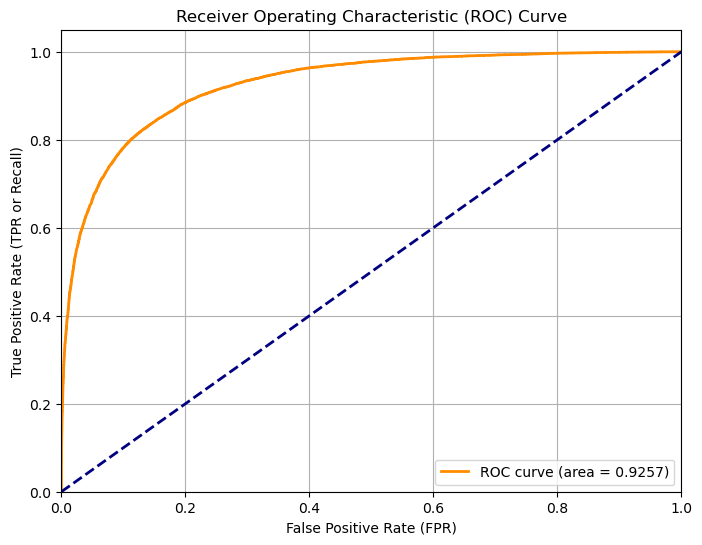

In [156]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score

y_pred_dnn = model.predict(X_Test_scaled)
fpr, tpr, thresh_holds = roc_curve(y_test, y_pred_dnn)
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR or Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

<Figure size 800x800 with 0 Axes>

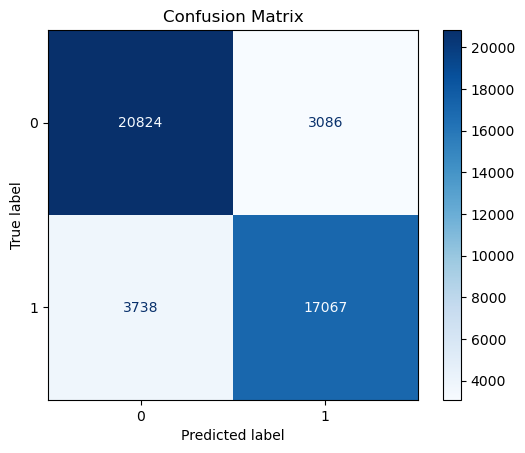

In [151]:
y_scores = y_pred_dnn.flatten() 

# 2. Apply the threshold of 0.5 (Standard)
# If the probability is >= 0.5, classify as 1 (Signal); otherwise, classify as 0 (Background)
threshold = 0.5
y_pred = (y_scores >= threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])

plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

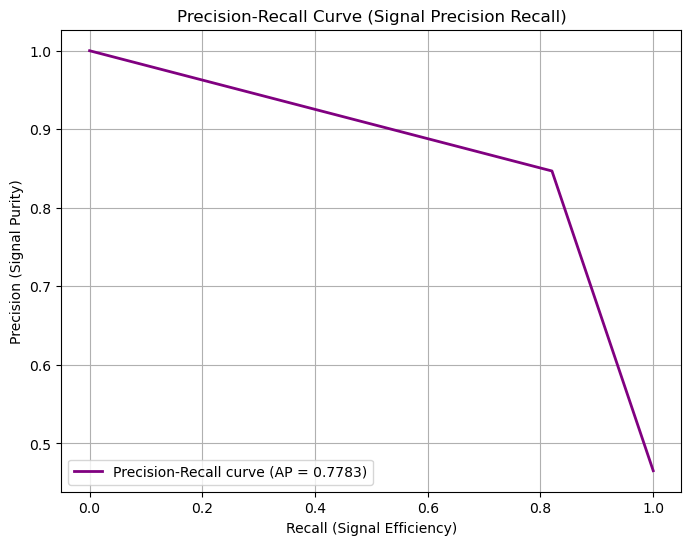

In [149]:
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label='Precision-Recall curve (AP = %0.4f)' % average_precision)
plt.xlabel('Recall (Signal Efficiency)')
plt.ylabel('Precision (Signal Purity)')
plt.title('Precision-Recall Curve (Signal Precision Recall)')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

In [150]:
loss, accuracy, auc = model.evaluate(X_Test_scaled, y_test, verbose=0)

print(f"Test Set Accuracy: {accuracy:.4f}")

Test Set Accuracy: 0.8474


In [155]:
y_test[Y==1].shape

(20805,)